https://en.wikipedia.org/wiki/Hierarchical_Data_Format

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from util.atlas import Atlas
from brainspace.gradient import GradientMaps
# from sklearn.decomposition import PCA
from util import plot

In [2]:
%cd ..

/mnt/cup/labs/hasson/zaid/narrative-enc


/usr/people/zzada/.conda/envs/fconv2/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
atlas = Atlas.schaefer(parcels=1000, networks=7, kong=False)
print(atlas.labels)

['17networks_LH_DefaultA_FPole_1', '17networks_LH_DefaultA_FPole_2', '17networks_LH_DefaultA_FPole_3', '17networks_LH_DefaultA_IPL_1', '17networks_LH_DefaultA_IPL_2', '17networks_LH_DefaultA_IPL_3', '17networks_LH_DefaultA_IPL_4', '17networks_LH_DefaultA_IPL_5', '17networks_LH_DefaultA_IPL_6', '17networks_LH_DefaultA_PCC_1', '17networks_LH_DefaultA_PCC_2', '17networks_LH_DefaultA_PFCd_1', '17networks_LH_DefaultA_PFCm_1', '17networks_LH_DefaultA_PFCm_2', '17networks_LH_DefaultA_PFCm_3', '17networks_LH_DefaultA_PFCm_4', '17networks_LH_DefaultA_PFCm_5', '17networks_LH_DefaultA_PFCm_6', '17networks_LH_DefaultA_PFCm_7', '17networks_LH_DefaultA_PFCm_8', '17networks_LH_DefaultA_PFCm_9', '17networks_LH_DefaultA_PHC_1', '17networks_LH_DefaultA_PHC_2', '17networks_LH_DefaultA_Temp_1', '17networks_LH_DefaultA_Temp_2', '17networks_LH_DefaultA_Temp_3', '17networks_LH_DefaultA_Temp_4', '17networks_LH_DefaultA_TempPole_1', '17networks_LH_DefaultA_TempPole_2', '17networks_LH_DefaultA_pCun_1', '17netwo

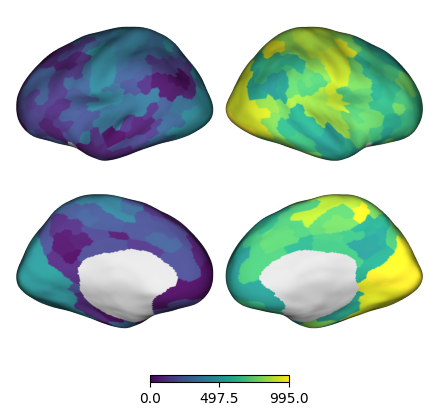

In [10]:
plot.surface_plot(atlas.label_img, cmap='viridis', vmin=0);

# across story file info

same for group and individual

in folders `encoding` and `encoding_group`

## keys
* actual1 - actual time series of FORGOT
* actual2 - actual time series of BLACK
* pred1 - predicted time series of FORGOT
* pred2 - predicted time series of BLACK
* scores1 - pearsonr correlation between actual and predicted for trained BLACK, tested on FORGOT
* scores2 - pearsonr correlation between actual and predicted for (vice versa)

## bands
for predicted
* 0 - is task
* 1 - is embedding

## grouped

In [4]:
filename = 'encoding_group/black/sub-000/model-gemma-2b_layer-16/sub-000.h5'
with h5py.File(filename, 'r') as f:
    for key in f.keys():
        print(key, f[key].shape)
    
    # actual_black = f['actual2'][...]
    actual_black = f['preds2'][1, ...]
    scores_black = f['scores2'][1, :]

actual1 (558, 81924)
actual2 (534, 81924)
preds1 (2, 558, 81924)
preds2 (2, 534, 81924)
scores1 (2, 81924)
scores2 (2, 81924)


In [5]:
actual_black_parc = atlas.vox_to_parc(actual_black)  # 
scores_black_parc = atlas.vox_to_parc(scores_black)
actual_black_parc.shape

(534, 1000)

In [6]:
D = 1 - squareform(pdist(actual_black_parc.T, metric='correlation'))
D.shape

(1000, 1000)

In [14]:
Dscores = np.outer(np.abs(scores_black_parc), np.abs(scores_black_parc))
Dscores.shape

(1000, 1000)

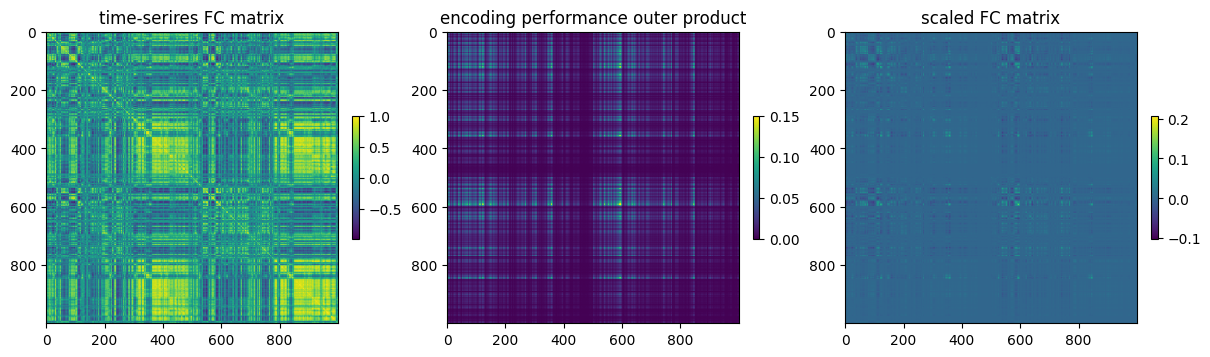

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), layout='constrained')

im = axes[0].imshow(D)
fig.colorbar(im, ax=axes[0], shrink=0.25)
axes[0].set_title('time-serires FC matrix')

im = axes[1].imshow(Dscores, vmin=0, vmax=0.15)
fig.colorbar(im, ax=axes[1], shrink=0.25)
axes[1].set_title('encoding performance outer product')

im = axes[2].imshow(np.abs(Dscores) * D)
fig.colorbar(im, ax=axes[2], shrink=0.25)
axes[2].set_title('scaled FC matrix')

fig.show()

In [36]:
fc_matrix = D
fc_matrix = Dscores
fc_matrix = np.abs(Dscores) * D

gm = GradientMaps(n_components=10, approach='pca')
gm = gm.fit(fc_matrix)
gm.gradients_.shape

(1000, 10)

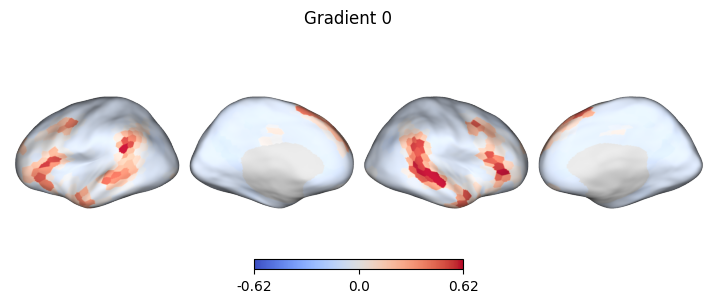

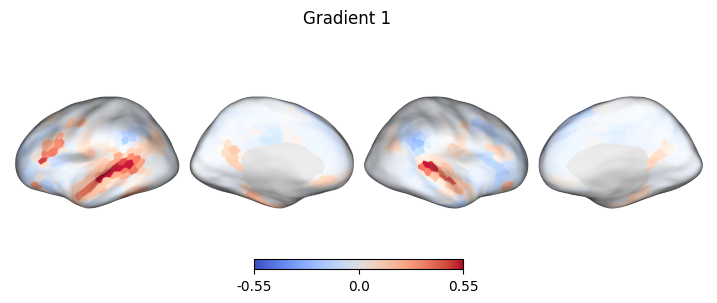

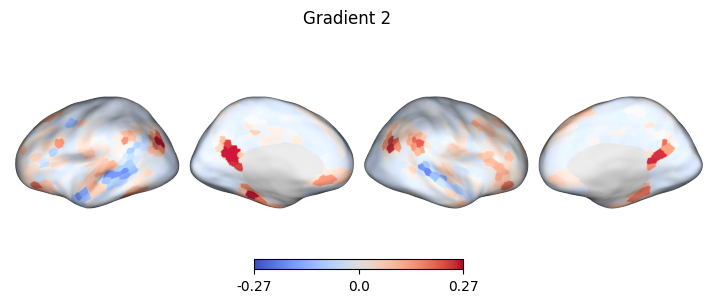

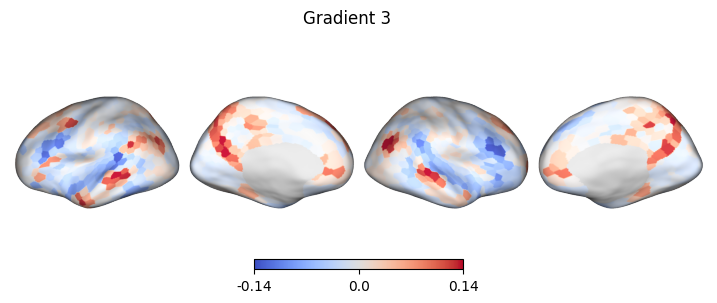

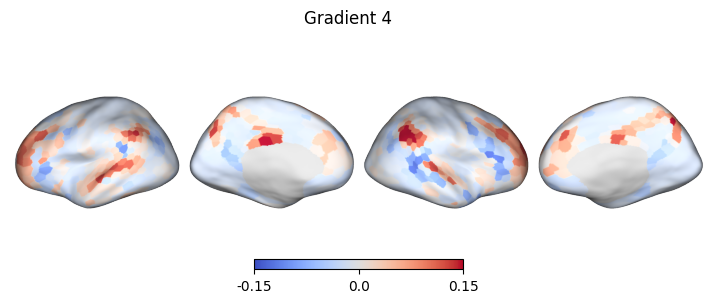

In [37]:
for i in range(5):
    plot.surface_plot(atlas.parc_to_vox(gm.gradients_[:, i]), title=f'Gradient {i}', size=(800, 200), zoom=1.2, layout='row')

# single subject, across story

In [60]:
filename = 'encoding/black/sub-127/model-gemma-2b_layer-16/sub-127.h5'
with h5py.File(filename, 'r') as f:
    for key in f.keys():
        print(key, f[key].shape)

actual1 (558, 81924)
actual2 (534, 81924)
preds1 (2, 558, 81924)
preds2 (2, 534, 81924)
scores1 (2, 81924)
scores2 (2, 81924)


## 2-fold structure

    cv_actual (2, 267, 81924)  - (fold, TRs, vertices)
    cv_preds (2, 2, 267, 81924) - (fold, band, TRs, vertices)
    cv_scores (2, 2, 81924) - (fold, band, vertices)

bands are same as above

In [61]:
filename = 'encoding_2fold/black/sub-127/model-gemma-2b_layer-16/sub-127.h5'
with h5py.File(filename, 'r') as f:
    for key in f.keys():
        print(key, f[key].shape)

cv_actual (2, 267, 81924)
cv_preds (2, 2, 267, 81924)
cv_scores (2, 2, 81924)


# outputs of LLMs

* gpt2  1024
* llama 2048
* gemma 8192 context length

In [69]:
filename = 'features/model-gemma-2b_layer-16/desc-forgot.h5'
df = pd.read_hdf(filename)
df

,word_idx,word,start,end,score,hftoken,token_id,rank,true_prob,entropy,embedding
0,0,This,0.868,0.968,0.485,▁This,1417,1504,3.472367e-05,5.685829,"[4.172836, 0.86464536, 4.899691, -0.75992274, ..."
1,1,is,1.048,1.108,0.942,▁is,603,0,1.211070e-04,6.216260,"[-0.84201753, -0.99294007, 5.590545, 1.6503977..."
2,2,a,1.188,1.228,0.186,▁a,476,0,1.745152e-04,3.906463,"[1.7583766, -0.81780094, 6.028924, -4.929085, ..."
3,3,story,1.248,1.648,0.795,▁story,3904,13,3.771459e-07,7.099531,"[-2.688942, 4.0940595, 3.4701838, -0.76090455,..."
4,4,that,2.229,2.349,0.807,▁that,674,2,6.056363e-05,1.895980,"[1.1220998, 1.4835855, 3.213122, -3.4109297, -..."
...,...,...,...,...,...,...,...,...,...,...,...
2617,2127,"D,",816.767,816.967,0.819,",",235269,0,7.763152e-04,0.889890,"[-5.7317553, 2.7693343, 2.485074, 3.4781728, -..."
2618,2128,"E,",816.987,817.007,0.000,▁E,637,0,1.243831e-05,1.188386,"[-3.4714475, -1.1490749, -4.004623, 2.6864812,..."
2619,2128,"E,",816.987,817.007,0.000,",",235269,0,7.763152e-04,0.845143,"[-0.3564751, 4.468419, 2.4143796, 4.9710746, -..."
2620,2129,F.,818.409,818.429,0.000,▁F,633,0,9.015241e-06,0.943336,"[-4.837492, -2.3454175, -3.459684, 6.103593, 0..."
